# Capsule Network model on Pneumonia dataset

An adaptation from the MNIST baseline model created in the other file named such

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

## Initialisation and setup

### Hyperparameters

In [ ]:
img_size = 28
cutoff = 128  # 0 == use all

epochs = 2
batch_size = 64

In [5]:
capsule_iterations = 3

num_filters = 256
num_base_mappings = 32
dim_base_capsules = num_filters // num_base_mappings

num_labels = 2
dim_super_capsules = 16

### Loading in the dataset

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
img_size = 28

def get_training_data(data_dir, img_size=150):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

In [ ]:
train_set150 = get_training_data('Data/chest_xray/chest_xray/train', 150)
test_set150 = get_training_data('Data/chest_xray/chest_xray/test', 150)

train_set56 = get_training_data('Data/chest_xray/chest_xray/train', 56)
test_set56 = get_training_data('Data/chest_xray/chest_xray/test', 56)

train_set28 = get_training_data('Data/chest_xray/chest_xray/train', 28)
test_set28 = get_training_data('Data/chest_xray/chest_xray/test', 28)

In [ ]:
if img_size == 28:
    train_set = train_set28
    test_set = test_set28
elif img_size == 56:
    train_set = train_set56
    test_set = test_set56
else:
    train_set = train_set150
    test_set = test_set150

In [8]:
X_train = []
y_train = []
for feature, label in train_set:
    X_train.append(feature)
    y_train.append(label)

X_test = []
y_test = []
for feature, label in test_set:
    X_test.append(feature)
    y_test.append(label)

NameError: name 'train_set' is not defined

In [ ]:
# (X_train, y_train), (X_test , y_test) = tf.keras.datasets.mnist.load_data()

#### Normalisation

In [ ]:
X_train = np.array(X_train) / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = np.array(X_test) / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)


y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(TensorShape([5216, 28, 28, 1]), TensorShape([624, 28, 28, 1]))

#### Cutoff data used for quicker development

In [ ]:
# Use a smaller set for development and testing
if cutoff > 0:
    try:
        X_train, y_train = X_train[:cutoff], y_train[:cutoff]
    except Exception as e:
        pass
    try:
        X_test, y_test = X_test[:cutoff], y_test[:cutoff]
    except Exception as e:
        pass

#### Process and augment data

In [ ]:
n_trainset = X_train.shape[0]
n_testset = X_test.shape[0]

dim_imgs = X_train.shape[1]

# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
# dataset = dataset.batch(batch_size=batch_size)

# testset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# testset = testset.batch(batch_size=batch_size)

In [ ]:
DataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
datagen = DataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X_train)

In [ ]:
augmented_dataset = datagen.flow(X_train, y_train)

X_train = augmented_dataset.x
y_train = augmented_dataset.y

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=batch_size)

testset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testset = testset.batch(batch_size=batch_size)

In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Util functions

In [ ]:
def get_layer_output_imgsize(input_size: int, kernel_size: int = 9, strides: int = 1):
    return (input_size - kernel_size) // strides

def get_img_dims(img) -> int:
    return img.shape[1], img.shape[2]

In [ ]:
def safe_normalise(vector, axis=1, epsilon=1e-7, keepdims=True):
    norm_squared = tf.reduce_sum(tf.square(vector), axis, keepdims)
    return tf.sqrt(norm_squared + epsilon)  # epsilon added to prevent division by 0

def safe_squash(vector, axis=1, epsilon=1e-7):
    norm_squared = tf.reduce_sum(
        tf.square(vector), 
        axis=axis, 
        keepdims=True
    )
    scalar_factor = norm_squared / (1 + norm_squared)
    
    safe_normalise = tf.sqrt(norm_squared + epsilon)  # epsilon added to prevent division by 0
    unit_vector = vector / safe_normalise
    return scalar_factor * unit_vector


In [ ]:
def loss_function(
    vector, 
    reconstructed_image, 
    y, 
    y_image,
    epsilon=1e-7,
    m_plus=0.9,
    m_minus=0.1,
    lambda_=0.5,
    alpha=0.0005,
):
    img_dim_w, img_dim_h = img_size, img_size
    img_resolution = img_dim_w * img_dim_h

    safe_normal = safe_normalise(vector, axis=-1, keepdims=True, epsilon=epsilon)
    prediction = tf.reshape(safe_normal, [-1, num_labels])

    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))

    margin_loss = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    margin_loss = tf.reduce_mean(tf.reduce_sum(margin_loss, axis=-1))

    y_image_flat = tf.reshape(y_image, [-1, img_resolution])
    # print(f"{y_image_flat.shape= }")
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))

    loss = tf.add(margin_loss, alpha * reconstruction_loss)

    return loss

## Building the Capsule Network class

In [ ]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(
        self, 
        num_filters, 
        num_base_mappings, dim_base_capsules, 
        num_labels, dim_super_capsules, 
        iterations: int = 3,
        kernel_size: int = 9):
        super().__init__()
        self.num_filters = num_filters  # 256
        self.num_base_mappings = num_base_mappings  # 32
        self.dim_base_capsules = dim_base_capsules  # 8
        self.num_labels = num_labels  # 10
        self.dim_super_capsules = dim_super_capsules  # 16
        self.num_base_capsules = self.num_base_mappings * 6 ** 2  # 1152

        self.iterations = iterations
        self.kernel_size = kernel_size

        with tf.name_scope("Variables") as scope:
            kernel = [self.kernel_size, self.kernel_size]
            
            self.convolution = tf.keras.layers.Conv2D(self.num_filters, kernel, strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.base_capsule = tf.keras.layers.Conv2D(self.num_base_mappings * self.dim_base_capsules, kernel, strides=[2,2], name="BaseCapsule")
            self.w = tf.Variable(
                tf.random_normal_initializer()(shape=[
                    1, 
                    self.num_base_capsules, self.num_labels, 
                    self.dim_super_capsules, self.dim_base_capsules
                    ]), 
                dtype=tf.float32, 
                name="PoseEstimation", 
                trainable=True)
            
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')

    def build(self, input_shape):
        pass

    def squash(self, vector, epsilon=1e-7):
        with tf.name_scope("SafeSquashFunction") as scope:
            norm_squared = tf.reduce_sum(
                tf.square(vector), 
                axis=-1, 
                keepdims=True
            )
            scalar_factor = norm_squared / (1 + norm_squared)
            
            safety_normalise = tf.sqrt(norm_squared + epsilon)
            unit_vector = vector / safety_normalise
            return scalar_factor * unit_vector

    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)

        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.base_capsule(x) # x.shape: (None, 6, 6, 256)
        # print(f"{x.shape= }")

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.num_base_capsules, self.dim_base_capsules)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], self.num_base_capsules, self.num_labels, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.iterations): # self.iterations = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement

        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)

        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.num_labels * self.dim_super_capsules]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)

        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.base_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.num_base_capsules, self.dim_base_capsules)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], self.num_base_capsules, self.num_labels, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.iterations): # self.iterations = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.num_labels * self.dim_super_capsules]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image



### Instantiate

In [ ]:
tf.summary.trace_on(graph=True, profiler=True)
model = CapsuleNetwork(
    num_filters=num_filters,
    num_base_mappings=num_base_mappings,
    dim_base_capsules=dim_base_capsules,
    num_labels=num_labels,
    dim_super_capsules=dim_super_capsules,
    iterations=capsule_iterations
)

In [ ]:
Optimiser = tf.keras.optimizers.Adam()

### Train

In [ ]:
def train(X, y) -> float:
    y_one_hot = tf.one_hot(y, depth=num_labels)
    with tf.GradientTape() as tape:
        vector, reconstructed_image = model([X, y_one_hot])
        loss = loss_function(vector, reconstructed_image, y_one_hot, X)
    grad = tape.gradient(loss, model.trainable_variables)
    Optimiser.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# _ = train(X_train[:32], y_train[:32])

tf.summary.trace_off()

In [ ]:
def predict(model, x):
    pred = model.predict_capsule_output(x)
    pred_normed = safe_normalise(pred)
    pred_normed = tf.squeeze(pred_normed, [1])
    return np.argmax(pred_normed, axis=1)[:,0]


In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:

        description = f"Epoch {i}/{epochs}"
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch, y_batch)
            pbar.update(1)

        loss /= len(dataset)
        losses.append(loss.numpy())

        training_sum = 0

        print_statement = f"Loss : {loss.numpy()}" + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/n_trainset)

        print_statement = f"Loss : {loss.numpy()} Accuracy : {accuracy[-1]}"

        pbar.set_postfix_str(print_statement)

Epoch 2/2: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s, Loss : 0.4042533040046692 Accuracy : 1.0]         


In [ ]:
test_sum = 0
for X_batch, y_batch in testset:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
print(test_sum/n_testset)

1.0


In [ ]:
model.save("Models/capsnet_tiny.keras")

In [ ]:
model.summary()

Model: "capsule_network_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ConvolutionLayer (Conv2D)       │ (64, 20, 20, 256)      │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BaseCapsule (Conv2D)            │ (64, 6, 6, 256)        │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (64, 512)              │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (64, 1024)             │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (64, 784)              │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,675,472 (25.46 MB)

 Trainable params: 6,675,472 (25.46 MB)

 Non-trainable params: 0 (0.00 B)

(5, 28, 28, 1)
(5, 1, 2, 16)


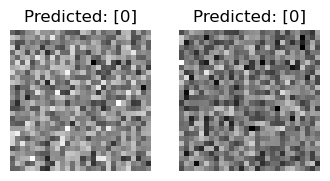

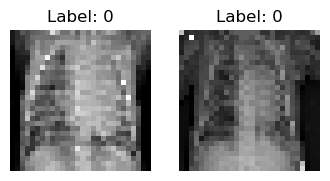

In [ ]:
n_samples = 5

test_sample = X_test[:n_samples]
features = model.predict_capsule_output(test_sample)

temp_features = features.numpy()
temp_ = temp_features.copy()


label_selection = num_labels
plt.figure(figsize=(label_selection * 2, 3))
for idx in range(label_selection):
    pred = predict(model, tf.expand_dims(X_test[idx], axis=0))

    temp_features[:,:,:,:] = 0
    temp_features[idx:,:,idx,:] = temp_[idx:,:,idx,:]

    reconstruction = model.regenerate_image(temp_features[idx])
    reconstruction = tf.reshape(reconstruction, (img_size, img_size))

    plt.subplot(1, label_selection, idx + 1)
    plt.imshow(reconstruction, cmap="gray")
    plt.title(f"Predicted: {pred}")
    plt.axis("off")
plt.show()   


plt.figure(figsize=(label_selection * 2, 3))
for idx in range(label_selection):
    label = y_test[idx]
    plt.subplot(1, label_selection, idx + 1)
    plt.imshow(test_sample[idx], cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.show()

In [ ]:
# idx = 4

# col = np.zeros((img_size, 308))
# for i in range(16): 
#     feature_ = temp_features.copy()
#     feature_[:,:,idx, i] += -0.25
#     row = np.zeros((img_size, img_size))
#     for j in range(10):
#         feature_[:,:,idx, i] += 0.05
#         feature_ = tf.convert_to_tensor(feature_)
#         print(feature_.shape)
#         row = np.hstack([
#             row, 
#             tf.reshape(model.regenerate_image(feature_), 
#             (img_size, img_size)).numpy()
#         ])
#     col = np.vstack([col, row])
    
# plt.figure(figsize=(30,20))
# plt.imshow(col[img_size:, img_size:], cmap='gray')